<a href="https://colab.research.google.com/github/mariamhergnyan/Molecular_Simulations_exam/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these before working.

In [1]:
!pip install pyemma > /dev/null
!pip install mdshare > /dev/null
#3 minutes

In [12]:
!pip install --upgrade google-colab


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.8/529.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 25.1.2
    Uninstalling pyzmq-25.1.2:
      Successfully uninstalled pyzmq-25.1.2
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 8.6.0
    Uninstalling jupyter_client-8.6.0:
      Successfully uninstalled jupyter_client-8.6.0
  Attempting uninstall: notebook
    Found existing installation: notebook 7.0.7
    Uninstalling notebook-7.0.7:
      Successfully uninstalled notebook-7.0.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nglview 3.1.1 requires notebook>=7, but you have notebook 6.5.5 which is incompatible.

In [2]:
!pip install nglview > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 7.0.7 which is incompatible.


In [3]:
!pip install biopython > /dev/null

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [5]:
from google.colab import output
output.disable_custom_widget_manager()

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview as nv
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer
from Bio.PDB import PDBParser
import pyemma.util.contexts as contexts



In [7]:
#mdshare.fetch is used for fetching from their server.
#In my case I have it locally, so it just should be the path

In [8]:
pdb = '/content/lb6-filtered.pdb'
files = '/content/lb6-filtered.xtc'


In [9]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

In [10]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
#compute a cross validated vamp 2 score
    # we temporarily suppress very short-lived progress bars
    with contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

<ipython-input-10-51e42bd11161>:9: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from <ipython-input-10-51e42bd11161> line 9. Use deeptime.decomposition.VAMP instead.
  vamp = pyemma.coordinates.vamp(
<ipython-input-10-51e42bd11161>:9: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from <ipython-input-10-51e42bd11161> line 9. Use deeptime.decomposition.VAMP instead.
  vamp = pyemma.coordinates.vamp(
<ipython-input-10-51e42bd11161>:9: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from <ipython-input-10-51e42bd11161> line 9. Use deeptime.decomposition.VAMP instead.
  vamp = pyemma.coordinates.vamp(
<ipython-input-10-51e42bd11161>:9: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from <ipython-input-10-51e42bd11161> line 9. Use deeptime.decomposition.VAMP instead.
  vamp = pyemma.coordinates.vamp(
<ipython-input-10-51e42bd11161>:9: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Ca

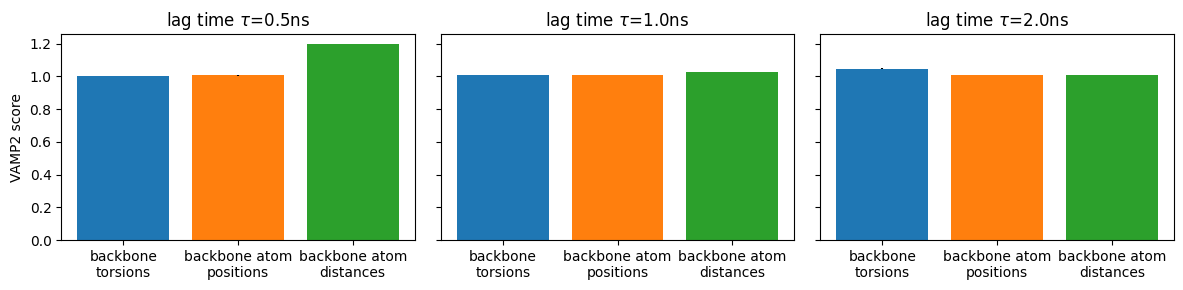

In [11]:
dim = 1 #used to be 10 in the tutorial

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

In [14]:
# Create an NGLview widget to display the PDB file - should tis display here? cuz it's not doing it
view = nv.show_file(pdb)
view.add_representation('cartoon')
view.center()
view

NGLWidget()

In [7]:
# Parse the PDB file using BioPython's PDBParser
parser = PDBParser()
structure = parser.get_structure('my_structure', '/content/lb6-filtered.pdb')

# Prepare coordinates for PyEmma
coordinates = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                coordinates.append(atom.get_coord())

# Convert coordinates to PyEmma's format (assuming 3D coordinates)
coordinates = [list(atom_coord) for atom_coord in coordinates]


# Perform PyEmma analysis (example: PCA)
#pca = pyemma.coordinates.pca(coordinates)


In [8]:
# Define the file path for saving the coordinates
txt_file = '/content/coordinates.txt'


# Write coordinates to a text file
with open(txt_file, 'w') as file:
    for coord in coordinates:
        file.write(','.join(map(str, coord)) + '\n')
